In [37]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
data_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/data/long_seqs_v11/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11'

if module_path not in sys.path:
    sys.path.append(module_path)

In [38]:
BATCH_SIZE = 256
T = 20
VOCAB = ['start', 'view', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

## Load Data

In [106]:
pos_data_path = os.path.join(data_path, 'positive_long_sequences.pickle')
# neg_data_path = os.path.join(data_path, 'negative_long_sequences.pickle')

def load_sequence_from_pickle_to_numpy(pickle_file_path, use_init_token=False):
    """
        A list of sequence in format of (event_type, time_delta)
    :param pickle_file_path: e.g. /.../project-basileus/seq-gan/data/fixed_length/valid_sequences.pickle
    :return: (event_type_seqs, time_delta)
    """
    with open(pickle_file_path, 'rb') as f:
        raw_seqs = pickle.load(f)

    if not raw_seqs or not raw_seqs[0]:
        return np.array([]), np.array([])

    N = len(raw_seqs)
    T = len(raw_seqs[0])
    
    seqs = np.array(raw_seqs)
        
    et_seqs = seqs[:, :, 0].astype(np.float64).reshape((N, T, 1))
    ts_seqs = seqs[:, :, 1].astype(np.float64).reshape((N, T, 1))
    
    return et_seqs, ts_seqs

raw_pos_event_type_seqs, raw_pos_timestamp_seqs = load_sequence_from_pickle_to_numpy(pos_data_path, use_init_token=False)

In [107]:
# cast indicator data into one-hot
pos_event_type_seqs = tf.cast(raw_pos_event_type_seqs, tf.int32)
pos_event_type_seqs = tf.one_hot(pos_event_type_seqs, depth=EVENT_VOCAB_DIM, axis=2, dtype=tf.float64)
pos_event_type_seqs = tf.squeeze(pos_event_type_seqs, axis=3)

In [141]:
def zcore_norm(data):
    N = data.shape[0]
    
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)
    _mean = tf.repeat(_mean, N, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return (data - _mean) / _std

def get_mean_std(data):
    _mean = tf.reduce_mean(data, axis=0)
    _mean = tf.expand_dims(_mean, axis=0)

    _std = tf.math.reduce_std(data, axis=0)
    _std = tf.expand_dims(_std, axis=0)

    return _mean, _std

def apply_mean_std(data, _mean, _std):
    N = data.shape[0]
    _mean = tf.repeat(_mean, N, axis=0)
    _std = tf.repeat(_std, N, axis=0)

    return data * _std + _mean

pos_timestamp_seqs = zcore_norm(raw_pos_timestamp_seqs)

In [16]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [17]:
def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

## Create multitype SeqGan

In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [19]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [20]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator

In [21]:
# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [24]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [25]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
#     # LSTM-token
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     # LSTM-time
#     G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.truncated_normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [26]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [34]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 3
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

46

In [35]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [36]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
token ce loss:1.391859274823286
time mae loss:0.9672658050323657
train loss:2.3591250798556516


1it [00:01,  1.15s/it]

Training Step: 2
token ce loss:1.3655450613355629
time mae loss:0.801971608509615
train loss:2.167516669845178


2it [00:02,  1.11s/it]

Training Step: 3
token ce loss:1.3575710789472661
time mae loss:0.8161169725439951
train loss:2.1736880514912613


3it [00:03,  1.08s/it]

Training Step: 4
token ce loss:1.3526876457135215
time mae loss:0.8281102558816663
train loss:2.180797901595188


4it [00:04,  1.12s/it]

Training Step: 5
token ce loss:1.3640889447888873
time mae loss:0.8168702040623754
train loss:2.1809591488512625


5it [00:05,  1.09s/it]

Training Step: 6
token ce loss:1.355940126680804
time mae loss:0.7923422898678361
train loss:2.14828241654864


6it [00:06,  1.08s/it]

Training Step: 7
token ce loss:1.3610586369283233
time mae loss:0.7975439364702457
train loss:2.1586025733985688


7it [00:07,  1.07s/it]

Training Step: 8
token ce loss:1.3476244812743274
time mae loss:0.7955256566832346
train loss:2.143150137957562


8it [00:08,  1.07s/it]

Training Step: 9
token ce loss:1.3366691286026593
time mae loss:0.7832816957017634
train loss:2.1199508243044227


9it [00:09,  1.07s/it]

Training Step: 10
token ce loss:1.3319850145561145
time mae loss:0.7930783464613294
train loss:2.125063361017444


10it [00:10,  1.06s/it]

Training Step: 11
token ce loss:1.3278497815614427
time mae loss:0.7866069937216033
train loss:2.114456775283046


11it [00:11,  1.07s/it]

Training Step: 12
token ce loss:1.3351812972779167
time mae loss:0.7912787937615906
train loss:2.1264600910395073


12it [00:12,  1.07s/it]

Training Step: 13
token ce loss:1.3324929552503975
time mae loss:0.797385529680654
train loss:2.1298784849310515


13it [00:13,  1.06s/it]

Training Step: 14
token ce loss:1.3378652074655997
time mae loss:0.7797304492309323
train loss:2.117595656696532


14it [00:15,  1.06s/it]

Training Step: 15
token ce loss:1.3257278083386048
time mae loss:0.7805860719517524
train loss:2.106313880290357


15it [00:16,  1.06s/it]

Training Step: 16
token ce loss:1.3273898355579064
time mae loss:0.7757007815829414
train loss:2.1030906171408477


16it [00:17,  1.06s/it]

Training Step: 17
token ce loss:1.3187021470847036
time mae loss:0.7765045796051264
train loss:2.09520672668983


17it [00:18,  1.05s/it]

Training Step: 18
token ce loss:1.3186001864673522
time mae loss:0.7799107096883461
train loss:2.098510896155698


18it [00:19,  1.06s/it]

Training Step: 19
token ce loss:1.3240758776943367
time mae loss:0.812382630752115
train loss:2.136458508446452


19it [00:20,  1.07s/it]

Training Step: 20
token ce loss:1.3176008004770736
time mae loss:0.7807694408737916
train loss:2.098370241350865


20it [00:21,  1.07s/it]

Training Step: 21
token ce loss:1.3199362125197012
time mae loss:0.7688146546811613
train loss:2.0887508672008623


21it [00:22,  1.06s/it]

Training Step: 22
token ce loss:1.3136556531876769
time mae loss:0.7743749268977403
train loss:2.0880305800854173


22it [00:23,  1.07s/it]

Training Step: 23
token ce loss:1.32147670645051
time mae loss:0.7773451164692234
train loss:2.0988218229197333


23it [00:24,  1.10s/it]

Training Step: 24
token ce loss:1.3163881573940788
time mae loss:0.7781708519612431
train loss:2.094559009355322


24it [00:25,  1.09s/it]

Training Step: 25
token ce loss:1.3119578421497091
time mae loss:0.7895918883451997
train loss:2.101549730494909


25it [00:26,  1.06s/it]

Training Step: 26
token ce loss:1.3090435126762903
time mae loss:0.773055476757934
train loss:2.082098989434224


26it [00:27,  1.06s/it]

Training Step: 27
token ce loss:1.3063296141110232
time mae loss:0.7895579029693209
train loss:2.095887517080344


27it [00:28,  1.06s/it]

Training Step: 28
token ce loss:1.307847699785209
time mae loss:0.78112427392462
train loss:2.088971973709829


28it [00:29,  1.06s/it]

Training Step: 29
token ce loss:1.3065879681162065
time mae loss:0.7840835703682629
train loss:2.0906715384844694


29it [00:31,  1.06s/it]

Training Step: 30
token ce loss:1.303671173408785
time mae loss:0.7842507329877698
train loss:2.087921906396555


30it [00:32,  1.06s/it]

Training Step: 31
token ce loss:1.2991418061233524
time mae loss:0.7759713859549496
train loss:2.075113192078302


31it [00:33,  1.07s/it]

Training Step: 32
token ce loss:1.3054078377786467
time mae loss:0.7951352701681242
train loss:2.1005431079467707


32it [00:34,  1.06s/it]

Training Step: 33
token ce loss:1.2982249102698042
time mae loss:0.7802399082384855
train loss:2.07846481850829


33it [00:35,  1.07s/it]

Training Step: 34
token ce loss:1.2994978095238647
time mae loss:0.7721987216900305
train loss:2.0716965312138953


34it [00:36,  1.07s/it]

Training Step: 35
token ce loss:1.297919452736324
time mae loss:0.7822394705517679
train loss:2.080158923288092


35it [00:37,  1.07s/it]

Training Step: 36
token ce loss:1.2956174121103028
time mae loss:0.7796933394943323
train loss:2.075310751604635


36it [00:38,  1.06s/it]

Training Step: 37
token ce loss:1.299685575765385
time mae loss:0.789864034961878
train loss:2.089549610727263


37it [00:39,  1.06s/it]

Training Step: 38
token ce loss:1.292215809214922
time mae loss:0.7775256216957502
train loss:2.069741430910672


38it [00:40,  1.06s/it]

Training Step: 39
token ce loss:1.2942895996433548
time mae loss:0.7870100568294326
train loss:2.0812996564727873


39it [00:41,  1.06s/it]

Training Step: 40
token ce loss:1.2972335436664477
time mae loss:0.7915431025575745
train loss:2.088776646224022


40it [00:42,  1.07s/it]

Training Step: 41
token ce loss:1.298076864019113
time mae loss:0.7789730127624649
train loss:2.0770498767815777


41it [00:43,  1.10s/it]

Training Step: 42
token ce loss:1.2943886205289814
time mae loss:0.7796886166143612
train loss:2.0740772371433427


42it [00:45,  1.09s/it]

Training Step: 43
token ce loss:1.2847370881082514
time mae loss:0.7707600405821116
train loss:2.055497128690363


43it [00:46,  1.08s/it]

Training Step: 44
token ce loss:1.2881501692884079
time mae loss:0.772387947390033
train loss:2.060538116678441


44it [00:47,  1.07s/it]

Training Step: 45
token ce loss:1.2878179762817286
time mae loss:0.7717142790101834
train loss:2.059532255291912


45it [00:48,  1.07s/it]

Training Step: 46
token ce loss:1.2906517466866239
time mae loss:0.7703969049199926
train loss:2.061048651606616


46it [00:49,  1.07s/it]


In [39]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [40]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_4 (TensorFlo [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

### pre-train D

In [41]:
N_fake_D = N_real_D = N_total_G 

In [42]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [50]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [51]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [52]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [53]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.6844135210169635


1it [00:00,  1.57it/s]

Training Step: 2
total discriminator loss:0.6692778131441446


2it [00:01,  1.68it/s]

Training Step: 3
total discriminator loss:0.6421025308571104


3it [00:01,  1.66it/s]

Training Step: 4
total discriminator loss:0.6477281243775592


4it [00:02,  1.69it/s]

Training Step: 5
total discriminator loss:0.615771478816243


5it [00:02,  1.72it/s]

Training Step: 6
total discriminator loss:0.6097842219767562


6it [00:03,  1.72it/s]

Training Step: 7
total discriminator loss:0.708943186604545


7it [00:04,  1.72it/s]

Training Step: 8
total discriminator loss:0.6351500788554647


8it [00:04,  1.72it/s]

Training Step: 9
total discriminator loss:0.580040914046


9it [00:05,  1.69it/s]

Training Step: 10
total discriminator loss:0.6561272794699551


10it [00:05,  1.68it/s]

Training Step: 11
total discriminator loss:0.6150209000062699


11it [00:06,  1.68it/s]

Training Step: 12
total discriminator loss:0.5644818282521501


12it [00:07,  1.69it/s]

Training Step: 13
total discriminator loss:0.5739392326861719


13it [00:07,  1.76it/s]

Training Step: 14
total discriminator loss:0.5701292106095265


14it [00:08,  1.73it/s]

Training Step: 15
total discriminator loss:0.595645004286019


15it [00:08,  1.73it/s]

Training Step: 16
total discriminator loss:0.565248812098779


16it [00:09,  1.73it/s]

Training Step: 17
total discriminator loss:0.5555291681816965


17it [00:09,  1.72it/s]

Training Step: 18
total discriminator loss:0.5183401637803091


18it [00:10,  1.72it/s]

Training Step: 19
total discriminator loss:0.5044927007207127


19it [00:11,  1.74it/s]

Training Step: 20
total discriminator loss:0.5054077396611673


20it [00:11,  1.73it/s]

Training Step: 21
total discriminator loss:0.4670143429225392


21it [00:12,  1.71it/s]

Training Step: 22
total discriminator loss:0.467028299574522


22it [00:12,  1.71it/s]

Training Step: 23
total discriminator loss:0.4262633450214662


23it [00:13,  1.72it/s]

Training Step: 24
total discriminator loss:0.4483457621821991


24it [00:14,  1.71it/s]

Training Step: 25
total discriminator loss:0.44892173320104456


25it [00:14,  1.70it/s]

Training Step: 26
total discriminator loss:0.40573094928541603


26it [00:15,  1.69it/s]

Training Step: 27
total discriminator loss:0.45627325771880356


27it [00:15,  1.69it/s]

Training Step: 28
total discriminator loss:0.4003868123580524


28it [00:16,  1.69it/s]

Training Step: 29
total discriminator loss:0.38803852404463834


29it [00:16,  1.69it/s]

Training Step: 30
total discriminator loss:0.4005658886956408


30it [00:17,  1.70it/s]

Training Step: 31
total discriminator loss:0.3718736721398605


31it [00:18,  1.71it/s]


In [54]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [55]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_8 (TensorFlo [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

## Gumbel  Traning

In [66]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [76]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_16 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [77]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-3)

_G_STEPS = 1
_D_STEPS = 1

0it [00:00, ?it/s]

Training Step: 0
generator loss:1.7802187026067688
-----------------------
total discriminator loss:1.0202944528595235
average true return:0.6904657715280089
-----------------------
tf.Tensor([[0 2 2 2 0 2 2 2 1 2 3 2 3 3 1 2 0 2 2 2]], shape=(1, 20), dtype=int64)


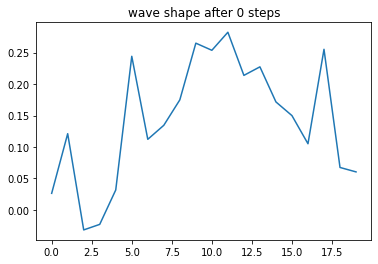

1it [00:02,  2.57s/it]

Training Step: 1
generator loss:1.5938798647380124
-----------------------


2it [00:04,  2.21s/it]

total discriminator loss:1.3120059988766766
average true return:0.32255596396390895
-----------------------
Training Step: 2
generator loss:1.1347181721136432
-----------------------


3it [00:06,  2.09s/it]

total discriminator loss:1.4066245267656479
average true return:0.3508225591924573
-----------------------
Training Step: 3
generator loss:0.7788606389044903
-----------------------


4it [00:08,  2.04s/it]

total discriminator loss:1.2077065797452664
average true return:0.4330459099071446
-----------------------
Training Step: 4
generator loss:0.6046322835892148
-----------------------


5it [00:10,  2.01s/it]

total discriminator loss:0.9250880753146583
average true return:0.5060830084224601
-----------------------
Training Step: 5
generator loss:0.5815377378837141
-----------------------


6it [00:12,  1.99s/it]

total discriminator loss:0.7986335156414562
average true return:0.5348675639562881
-----------------------
Training Step: 6
generator loss:0.6223192847197043
-----------------------


7it [00:14,  1.98s/it]

total discriminator loss:0.7187631585640922
average true return:0.5362083251439091
-----------------------
Training Step: 7
generator loss:0.6845015065944853
-----------------------


8it [00:16,  1.98s/it]

total discriminator loss:0.6678640140663972
average true return:0.5206412948179291
-----------------------
Training Step: 8
generator loss:0.7765867628027097
-----------------------


9it [00:18,  1.98s/it]

total discriminator loss:0.6211046419422459
average true return:0.4918563927294725
-----------------------
Training Step: 9
generator loss:0.8874145962982507
-----------------------


10it [00:20,  1.97s/it]

total discriminator loss:0.5836379079247609
average true return:0.467180303715778
-----------------------
Training Step: 10
generator loss:1.0125238388718416
-----------------------


11it [00:22,  1.97s/it]

total discriminator loss:0.5560344005610826
average true return:0.4497316436985503
-----------------------
Training Step: 11
generator loss:1.1158579690230597
-----------------------


12it [00:24,  1.96s/it]

total discriminator loss:0.5140960043025292
average true return:0.4413550867321595
-----------------------
Training Step: 12
generator loss:1.199872846426918
-----------------------


13it [00:26,  1.96s/it]

total discriminator loss:0.47219825832917145
average true return:0.4460925220711911
-----------------------
Training Step: 13
generator loss:1.2435929399346264
-----------------------


14it [00:28,  2.02s/it]

total discriminator loss:0.46451938703605977
average true return:0.4602344912753238
-----------------------
Training Step: 14
generator loss:1.2428115024443305
-----------------------


15it [00:30,  2.00s/it]

total discriminator loss:0.4376678224462627
average true return:0.4809876854831101
-----------------------
Training Step: 15
generator loss:1.207851628282483
-----------------------


16it [00:32,  1.99s/it]

total discriminator loss:0.41762802354785605
average true return:0.5111362000037898
-----------------------
Training Step: 16
generator loss:1.1539705966216676
-----------------------


17it [00:34,  1.98s/it]

total discriminator loss:0.41906800838658564
average true return:0.531643716505942
-----------------------
Training Step: 17
generator loss:1.1169535676626596
-----------------------


18it [00:36,  1.97s/it]

total discriminator loss:0.39838184717500696
average true return:0.5403821325331454
-----------------------
Training Step: 18
generator loss:1.0887429377455258
-----------------------


19it [00:38,  1.96s/it]

total discriminator loss:0.3949091168407738
average true return:0.5417490528790814
-----------------------
Training Step: 19
generator loss:1.0582857064821622
-----------------------


20it [00:39,  1.96s/it]

total discriminator loss:0.3804840937652024
average true return:0.5408818119735485
-----------------------
Training Step: 20
generator loss:1.0263302465434174
-----------------------


21it [00:41,  1.96s/it]

total discriminator loss:0.3758791336595361
average true return:0.5349756168670897
-----------------------
Training Step: 21
generator loss:0.9925072930993865
-----------------------


22it [00:43,  1.96s/it]

total discriminator loss:0.36983509806073944
average true return:0.5363173651429869
-----------------------
Training Step: 22
generator loss:0.9344187869257077
-----------------------


23it [00:45,  1.96s/it]

total discriminator loss:1.5645997695019593
average true return:0.5399428679223935
-----------------------
Training Step: 23
generator loss:0.882850626523781
-----------------------


24it [00:47,  1.96s/it]

total discriminator loss:0.35390015571635985
average true return:0.544465292000068
-----------------------
Training Step: 24
generator loss:0.8756506704862793
-----------------------


25it [00:49,  1.96s/it]

total discriminator loss:0.3395622522130268
average true return:0.5390955022063157
-----------------------
Training Step: 25
generator loss:0.9077875232417103
-----------------------
total discriminator loss:0.3790983950103588
average true return:0.5240881372077888
-----------------------
tf.Tensor([[2 2 0 1 1 1 0 1 1 2 0 2 0 1 1 2 0 0 1 1]], shape=(1, 20), dtype=int64)


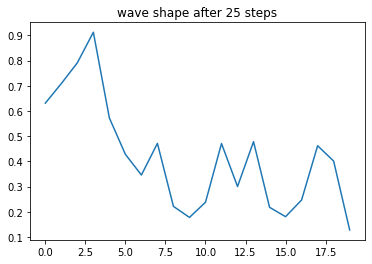

26it [00:52,  2.13s/it]

Training Step: 26
generator loss:0.9461152746410324
-----------------------


27it [00:54,  2.08s/it]

total discriminator loss:0.3681066568369613
average true return:0.504236964139461
-----------------------
Training Step: 27
generator loss:0.9968619943750742
-----------------------


28it [00:56,  2.04s/it]

total discriminator loss:1.4473379346262916
average true return:0.4832711687564516
-----------------------
Training Step: 28
generator loss:1.0276518123045233
-----------------------


29it [00:58,  2.03s/it]

total discriminator loss:0.40437687746517736
average true return:0.4557972165123343
-----------------------
Training Step: 29
generator loss:1.0596612805536227
-----------------------


30it [01:00,  2.06s/it]

total discriminator loss:0.47291850522752954
average true return:0.429464684047673
-----------------------
Training Step: 30
generator loss:0.9970940793890545
-----------------------


31it [01:02,  2.03s/it]

total discriminator loss:0.45123713262058873
average true return:0.47164295715676463
-----------------------
Training Step: 31
generator loss:0.7348338529063071
-----------------------


32it [01:04,  2.01s/it]

total discriminator loss:0.5471804017414419
average true return:0.6364016781783198
-----------------------
Training Step: 32
generator loss:0.3375042415099191
-----------------------


33it [01:06,  2.00s/it]

total discriminator loss:0.9160047447835697
average true return:0.7777006772939603
-----------------------
Training Step: 33
generator loss:0.27141673608920047
-----------------------


34it [01:08,  1.99s/it]

total discriminator loss:0.8952478335820888
average true return:0.754121183025018
-----------------------
Training Step: 34
generator loss:0.3372746003976662
-----------------------


35it [01:10,  1.98s/it]

total discriminator loss:0.7284218647414519
average true return:0.6922011932402676
-----------------------
Training Step: 35
generator loss:0.5137273656546811
-----------------------


36it [01:12,  1.96s/it]

total discriminator loss:0.9372301773201879
average true return:0.5530765847034067
-----------------------
Training Step: 36
generator loss:0.9203395234133903
-----------------------


37it [01:14,  1.95s/it]

total discriminator loss:1.1787877055404814
average true return:0.397756822517615
-----------------------
Training Step: 37
generator loss:1.2555640497225966
-----------------------


38it [01:15,  1.95s/it]

total discriminator loss:1.3204514028409786
average true return:0.3140934113018938
-----------------------
Training Step: 38
generator loss:1.3137607436986185
-----------------------


39it [01:17,  1.94s/it]

total discriminator loss:1.2121250334072182
average true return:0.2905126060138569
-----------------------
Training Step: 39
generator loss:1.248865789771506
-----------------------


40it [01:19,  1.94s/it]

total discriminator loss:1.1253736665359884
average true return:0.288320450612569
-----------------------
Training Step: 40
generator loss:1.1702809387547695
-----------------------


41it [01:21,  1.94s/it]

total discriminator loss:1.0470616672119013
average true return:0.2945586424802796
-----------------------
Training Step: 41
generator loss:1.0976886348504875
-----------------------


42it [01:23,  1.94s/it]

total discriminator loss:0.9529837734335749
average true return:0.30129942516204744
-----------------------
Training Step: 42
generator loss:1.0233766299605687
-----------------------


43it [01:25,  1.94s/it]

total discriminator loss:0.8918806436299352
average true return:0.3236138911927404
-----------------------
Training Step: 43
generator loss:0.9034643228975776
-----------------------


44it [01:27,  1.95s/it]

total discriminator loss:0.8402533519330107
average true return:0.3682236660759286
-----------------------
Training Step: 44
generator loss:0.786307068739162
-----------------------


45it [01:29,  1.95s/it]

total discriminator loss:0.8228195001414536
average true return:0.41867191373395696
-----------------------
Training Step: 45
generator loss:0.680209466666725
-----------------------


46it [01:31,  1.95s/it]

total discriminator loss:0.8017095344111392
average true return:0.4729158251821588
-----------------------
Training Step: 46
generator loss:0.6095089618331551
-----------------------


47it [01:33,  1.96s/it]

total discriminator loss:0.7777077012888256
average true return:0.514863922332728
-----------------------
Training Step: 47
generator loss:0.5762409446560317
-----------------------


48it [01:35,  1.96s/it]

total discriminator loss:0.7496371300837696
average true return:0.542880755671788
-----------------------
Training Step: 48
generator loss:0.5889110118900673
-----------------------


49it [01:37,  1.96s/it]

total discriminator loss:0.7025565871176251
average true return:0.5538507438802829
-----------------------
Training Step: 49
generator loss:0.6323877493130416
-----------------------


50it [01:39,  2.01s/it]

total discriminator loss:0.6524701430102089
average true return:0.5503115644115384
-----------------------
Training Step: 50
generator loss:0.7253672143199514
-----------------------
total discriminator loss:0.541845049355665
average true return:0.5019739268260135
-----------------------
tf.Tensor([[3 0 2 0 3 2 2 3 3 3 3 1 3 3 3 3 2 2 3 2]], shape=(1, 20), dtype=int64)


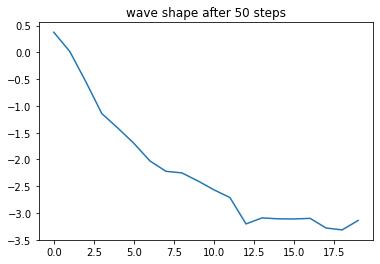

51it [01:42,  2.17s/it]

Training Step: 51
generator loss:1.1820162607760767
-----------------------


52it [01:44,  2.10s/it]

total discriminator loss:0.44693930560007955
average true return:0.4277095661160214
-----------------------
Training Step: 52
generator loss:1.170800508310857
-----------------------


53it [01:45,  2.06s/it]

total discriminator loss:0.4364256113978334
average true return:0.43568623629311126
-----------------------
Training Step: 53
generator loss:1.2099515196182995
-----------------------


54it [01:47,  2.03s/it]

total discriminator loss:0.43422438427193777
average true return:0.43933417422155113
-----------------------
Training Step: 54
generator loss:1.227300233161617
-----------------------


55it [01:49,  2.01s/it]

total discriminator loss:0.4445768711587096
average true return:0.44089781030581265
-----------------------
Training Step: 55
generator loss:1.2192245724593227
-----------------------


56it [01:51,  2.00s/it]

total discriminator loss:0.4217190201244098
average true return:0.45179915942245297
-----------------------
Training Step: 56
generator loss:1.1814184879424057
-----------------------


57it [01:53,  1.99s/it]

total discriminator loss:0.40402840031945375
average true return:0.4699122071335201
-----------------------
Training Step: 57
generator loss:1.114397605331536
-----------------------


58it [01:55,  1.98s/it]

total discriminator loss:0.38860949141371065
average true return:0.48680847061448984
-----------------------
Training Step: 58
generator loss:1.0592288825046468
-----------------------


59it [01:57,  1.98s/it]

total discriminator loss:1.4937074790535732
average true return:0.4984874157022662
-----------------------
Training Step: 59
generator loss:0.9691053588650002
-----------------------


60it [01:59,  1.97s/it]

total discriminator loss:0.3894824007705201
average true return:0.5175543124932185
-----------------------
Training Step: 60
generator loss:0.8947700552843292
-----------------------


61it [02:01,  1.97s/it]

total discriminator loss:0.3873675401893865
average true return:0.537185247257432
-----------------------
Training Step: 61
generator loss:0.8190730490049962
-----------------------


62it [02:03,  1.96s/it]

total discriminator loss:0.38084450932855995
average true return:0.5579107354909132
-----------------------
Training Step: 62
generator loss:0.774587400246174
-----------------------


63it [02:05,  1.96s/it]

total discriminator loss:0.3793327217175899
average true return:0.5697754546086017
-----------------------
Training Step: 63
generator loss:0.7525801022644455
-----------------------


64it [02:07,  1.95s/it]

total discriminator loss:0.3520200221236264
average true return:0.5779541773923884
-----------------------
Training Step: 64
generator loss:0.7409719241339991
-----------------------


65it [02:09,  1.94s/it]

total discriminator loss:0.3742276343290797
average true return:0.5798059886275482
-----------------------
Training Step: 65
generator loss:0.7534289932187846
-----------------------


66it [02:11,  1.94s/it]

total discriminator loss:0.36258974305925207
average true return:0.5750657633416588
-----------------------
Training Step: 66
generator loss:0.7778536140205972
-----------------------


67it [02:13,  1.94s/it]

total discriminator loss:0.36303313316295316
average true return:0.5686552765084598
-----------------------
Training Step: 67
generator loss:0.8188137366984576
-----------------------


68it [02:15,  1.99s/it]

total discriminator loss:0.33918023426391075
average true return:0.55573404324769
-----------------------
Training Step: 68
generator loss:0.862167847221747
-----------------------


69it [02:17,  1.98s/it]

total discriminator loss:0.3296663389586383
average true return:0.5454010599291028
-----------------------
Training Step: 69
generator loss:0.9170645723864904
-----------------------


70it [02:19,  1.97s/it]

total discriminator loss:0.3386828773226711
average true return:0.5336253984305892
-----------------------
Training Step: 70
generator loss:0.9643862836923326
-----------------------


71it [02:21,  1.97s/it]

total discriminator loss:0.30152171546572093
average true return:0.5236399049020466
-----------------------
Training Step: 71
generator loss:1.0220383521574607
-----------------------


72it [02:23,  1.97s/it]

total discriminator loss:0.3245189032191187
average true return:0.5135796009466631
-----------------------
Training Step: 72
generator loss:1.0625585572913099
-----------------------


73it [02:25,  1.97s/it]

total discriminator loss:0.3203559528662535
average true return:0.5054161199392444
-----------------------
Training Step: 73
generator loss:1.1100147287665423
-----------------------


74it [02:27,  1.96s/it]

total discriminator loss:0.3112598401814911
average true return:0.49763252253170565
-----------------------
Training Step: 74
generator loss:1.1567046452253829
-----------------------


75it [02:29,  1.96s/it]

total discriminator loss:0.33265402087892254
average true return:0.49174918523469274
-----------------------
Training Step: 75
generator loss:1.1917764242635949
-----------------------
total discriminator loss:0.29045089565223614
average true return:0.48915533958971225
-----------------------
tf.Tensor([[2 1 0 1 3 3 2 1 1 2 2 3 2 2 2 3 3 3 2 3]], shape=(1, 20), dtype=int64)


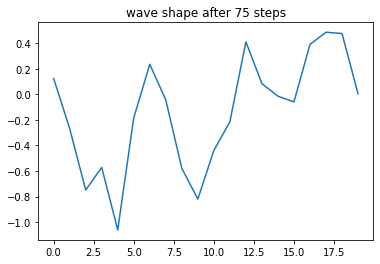

76it [02:31,  2.13s/it]

Training Step: 76
generator loss:1.2341559752026758
-----------------------


77it [02:33,  2.08s/it]

total discriminator loss:0.32248189081288536
average true return:0.4855824280695036
-----------------------
Training Step: 77
generator loss:1.2690098103885745
-----------------------


78it [02:35,  2.04s/it]

total discriminator loss:0.30324816668674137
average true return:0.48334086430639445
-----------------------
Training Step: 78
generator loss:1.2957093134870792
-----------------------


79it [02:37,  2.02s/it]

total discriminator loss:0.30540642689049013
average true return:0.48016241271601484
-----------------------
Training Step: 79
generator loss:1.3198668409848797
-----------------------


80it [02:39,  2.00s/it]

total discriminator loss:0.30875769736144765
average true return:0.4816347245784411
-----------------------
Training Step: 80
generator loss:1.3286392744770525
-----------------------


81it [02:41,  1.99s/it]

total discriminator loss:0.3158972714121002
average true return:0.4801632360370316
-----------------------
Training Step: 81
generator loss:1.338518780381223
-----------------------


82it [02:43,  1.98s/it]

total discriminator loss:0.2893876793097748
average true return:0.4821804728588064
-----------------------
Training Step: 82
generator loss:1.3463141198459265
-----------------------


83it [02:45,  1.98s/it]

total discriminator loss:2.1816072641605464
average true return:0.4830298166105015
-----------------------
Training Step: 83
generator loss:1.2978808208097106
-----------------------


84it [02:47,  1.97s/it]

total discriminator loss:0.32622427476912885
average true return:0.4849931132108537
-----------------------
Training Step: 84
generator loss:1.2524123387716541
-----------------------


85it [02:49,  1.97s/it]

total discriminator loss:0.319689301549885
average true return:0.4868212343030122
-----------------------
Training Step: 85
generator loss:1.2091954397713716
-----------------------


86it [02:51,  2.03s/it]

total discriminator loss:0.3089063804055658
average true return:0.4896646628742062
-----------------------
Training Step: 86
generator loss:1.1657098126609347
-----------------------


87it [02:53,  2.02s/it]

total discriminator loss:0.31984119593379823
average true return:0.4950675380389486
-----------------------
Training Step: 87
generator loss:1.1255083214043586
-----------------------


88it [02:55,  2.00s/it]

total discriminator loss:0.2858313551309407
average true return:0.49946818446226027
-----------------------
Training Step: 88
generator loss:1.0970021183272995
-----------------------


89it [02:57,  2.00s/it]

total discriminator loss:0.2875662005444188
average true return:0.5029710371351062
-----------------------
Training Step: 89
generator loss:1.0647524811626532
-----------------------


90it [02:59,  1.99s/it]

total discriminator loss:0.33217356151672156
average true return:0.5061824895179379
-----------------------
Training Step: 90
generator loss:1.027953507910798
-----------------------


91it [03:01,  1.97s/it]

total discriminator loss:1.7939944135661174
average true return:0.512101188580592
-----------------------
Training Step: 91
generator loss:0.9534135426887819
-----------------------


92it [03:03,  1.96s/it]

total discriminator loss:0.33518280590733374
average true return:0.5282000663778899
-----------------------
Training Step: 92
generator loss:0.8292849540674128
-----------------------


93it [03:05,  1.95s/it]

total discriminator loss:0.44391312748903167
average true return:0.6059811379143427
-----------------------
Training Step: 93
generator loss:0.3522668927189646
-----------------------


94it [03:07,  1.96s/it]

total discriminator loss:0.9832246926763435
average true return:0.824254541231884
-----------------------
Training Step: 94
generator loss:0.18234031853588803
-----------------------


95it [03:09,  1.96s/it]

total discriminator loss:1.0199130792744628
average true return:0.8378578829076837
-----------------------
Training Step: 95
generator loss:0.2052298686989998
-----------------------


96it [03:11,  1.96s/it]

total discriminator loss:0.9644348235848299
average true return:0.8047576950570569
-----------------------
Training Step: 96
generator loss:0.2634829262501516
-----------------------


97it [03:13,  1.96s/it]

total discriminator loss:0.8685316683818729
average true return:0.7569776448696443
-----------------------
Training Step: 97
generator loss:0.34216918689117204
-----------------------


98it [03:14,  1.96s/it]

total discriminator loss:0.8083737689270264
average true return:0.6952570334507409
-----------------------
Training Step: 98
generator loss:0.4413664129427606
-----------------------


99it [03:16,  1.95s/it]

total discriminator loss:0.762570829810054
average true return:0.6270870217291293
-----------------------
Training Step: 99
generator loss:0.5555532680374089
-----------------------


100it [03:18,  1.99s/it]

total discriminator loss:0.7417232772485486
average true return:0.5520449777037434
-----------------------


In [78]:
_TOTAL_STEPS = 100
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch

    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
        
        
    if step % 25 == 0:
        _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(1, G, BATCH_SIZE, T)
        plt.figure()
        print(tf.argmax(_gen_seqs_et, axis=2))
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()
        
    step += 1

Text(0.5, 0, 'Training steps')

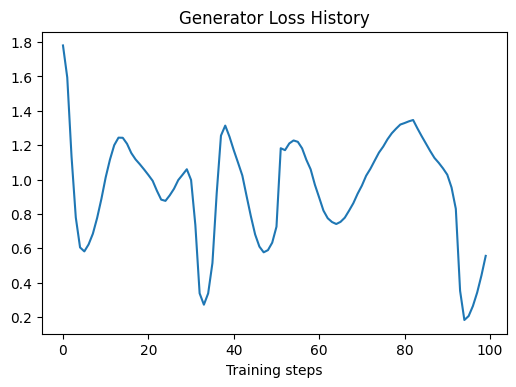

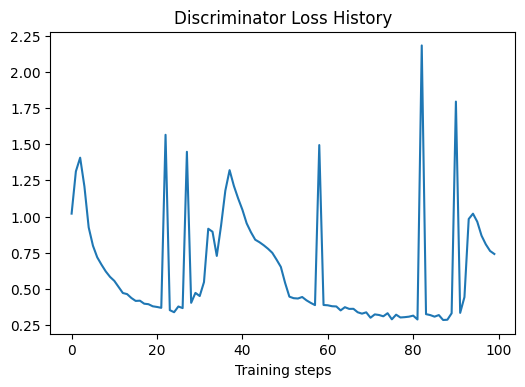

In [79]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [80]:
from matplotlib import pyplot as plt

tf.Tensor(
[[3 3 1 3 2 3 1 2 0 3 1 2 1 1 1 0 2 3 0 3]
 [0 0 3 3 0 1 3 3 0 0 0 1 0 0 1 1 2 1 2 3]
 [3 2 0 0 0 3 0 2 0 0 3 2 1 3 2 1 3 0 0 0]
 [0 2 0 0 2 3 0 2 0 2 2 0 1 0 3 3 3 2 1 2]
 [2 0 1 0 1 2 1 2 3 1 0 0 0 2 3 3 3 1 0 0]
 [1 3 3 2 2 2 2 0 0 0 1 1 2 0 3 0 0 3 0 0]
 [3 0 2 1 3 0 0 1 1 0 3 0 3 0 3 0 1 1 2 2]
 [0 2 0 2 3 1 2 0 2 0 1 3 1 3 2 3 0 2 3 1]
 [3 3 0 1 1 0 3 0 3 2 3 2 3 1 0 0 0 2 0 1]
 [1 2 2 3 2 2 0 2 2 1 0 0 0 1 3 3 1 0 2 2]], shape=(10, 20), dtype=int64)


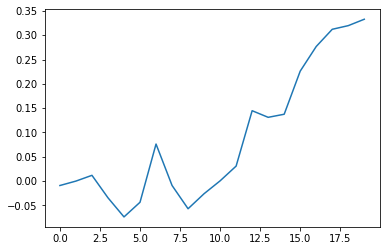

In [81]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(10, G0, BATCH_SIZE, T)
print(tf.argmax(seqs_random_et, axis=2))

ind = 1
x = np.arange(seqs_random_ts[ind,:,:].shape[0])
y = seqs_random_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[0 1 2 3 1 2 2 3 1 3 1 2 1 2 1 0 2 1 3 1]
 [2 1 0 0 1 1 2 2 2 3 3 2 2 1 0 3 1 2 2 1]
 [2 1 1 0 1 1 2 1 3 2 2 2 1 3 3 2 0 2 1 3]
 [0 2 3 1 0 1 1 2 1 0 2 2 0 2 1 3 2 1 0 2]
 [2 2 1 0 2 2 3 3 3 2 3 2 1 0 2 0 2 0 3 1]
 [3 2 2 3 2 1 1 1 2 0 2 1 0 2 1 1 2 2 2 0]
 [3 1 0 1 2 2 3 2 2 0 2 0 2 3 3 1 2 1 2 2]
 [2 2 3 3 1 1 1 2 0 2 2 1 0 0 2 1 0 2 1 1]
 [3 2 2 1 3 2 1 0 2 1 2 0 0 2 3 1 0 2 0 1]
 [2 0 1 2 0 2 2 3 3 1 3 2 1 0 3 2 2 1 3 0]], shape=(10, 20), dtype=int64)


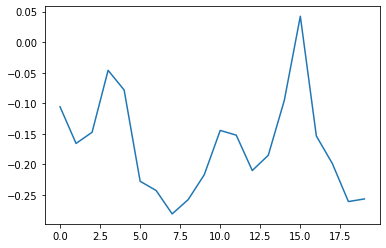

In [82]:
G1 = pretrained_generator
seqs_pretrained_et, seqs_pretrained_ts = generate_sequences_gumbel(10, G1, BATCH_SIZE, T)
print(tf.argmax(seqs_pretrained_et, axis=2))

ind = 1
x = np.arange(seqs_pretrained_ts[ind,:,:].shape[0])
y = seqs_pretrained_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[2 0 3 1 2 1 0 2 3 2 2 1 0 2 2 3 2 1 1 3]
 [1 1 1 0 2 3 1 2 3 1 1 1 0 2 2 0 1 0 3 1]
 [2 2 2 3 2 3 2 1 0 2 1 0 2 3 2 1 2 0 1 2]
 [0 2 2 1 0 1 0 1 0 0 2 2 2 3 0 0 0 2 2 1]
 [0 0 1 2 3 1 2 3 3 2 3 1 2 0 2 0 2 1 2 0]
 [2 3 1 1 0 2 1 2 2 1 0 0 3 2 3 2 2 0 3 2]
 [2 3 1 2 1 2 0 1 2 2 3 2 1 0 3 2 2 2 2 2]
 [3 1 0 1 0 1 3 1 2 2 2 1 1 2 0 1 2 2 3 1]
 [3 1 2 2 0 2 1 2 0 1 2 3 1 1 0 1 2 2 2 2]
 [1 0 1 2 1 0 3 2 2 3 2 0 1 1 1 2 2 0 1 0]], shape=(10, 20), dtype=int64)


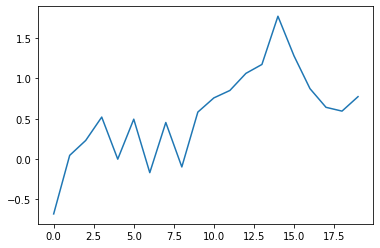

In [83]:
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(10, G2, BATCH_SIZE, T)

print(tf.argmax(seqs_trained_et, axis=2))

ind = 3
x = np.arange(seqs_trained_ts[ind,:,:].shape[0])
y = seqs_trained_ts[ind,:,:]

plt.plot(x, y)

## Save trained G and D weights

In [75]:
if not os.path.exists(model_save_dir + '/G_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/G_run_syn_v11_200')

G_save_path = model_save_dir + '/G_run_syn_v11_200/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_syn_v11_200'):
    os.makedirs(model_save_dir + '/D_run_syn_v11_200')

D_save_path = model_save_dir + '/D_run_syn_v11_200/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)

## Generate Synthesized data

In [87]:
G_save_path = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-v11/G_run_syn_v11_200/model.tf'

In [88]:
G_200 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G_200.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_16 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [145]:
raw_seqs_trained_et_200, raw_seqs_trained_ts_200 = generate_sequences_gumbel(400000, G_200, BATCH_SIZE, T)

In [148]:
seqs_save_et_200 = tf.argmax(raw_seqs_trained_et_200[:400000, :, :], axis=2)
seqs_save_ts_200 = apply_mean_std(raw_seqs_trained_ts_200[:400000, :, :], *get_mean_std(raw_pos_timestamp_seqs))

In [151]:
import pickle

pos_seqs_filename_et = 'syn_positive_type_sequences.pickle'
pos_seqs_filename_ts = 'syn_positive_time_sequences.pickle'

repo_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"

with open(os.path.join(repo_path, 'syn_data', 'combined_v0', pos_seqs_filename_et), 'wb') as f:
    pickle.dump(seqs_save_et_200, f)
    
with open(os.path.join(repo_path, 'syn_data', 'combined_v0', pos_seqs_filename_ts), 'wb') as f:
    pickle.dump(seqs_save_ts_200, f)